In [1]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )

# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import ipdb as ipdb

%matplotlib inline
sns.set_style("white")

In [2]:
fig_path = '../figures/'

# Years to load
start = 2007
end = 2015
# Sites to load (pulls list of AF sites from plot_nmeg module)
sites = ['Seg', 'Sen', 'Ses', 'Wjs', 'Mpj', 'Mpg', 'Vcp', 'Vcm']

In [4]:
daily_path = '/home/greg/current/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/'
# Fill a dict with multiyear dataframes for each site in sites
daily = { x : 
         ld.load_local_file( daily_path + 'US-' + x + '_daily_aflx.csv')
         for x in sites }
d = pd.Panel(daily)

ftp_path = '/home/greg/sftp/eddyflux/Ameriflux_files/FLUXNET2015_a/'
# Load 30min data
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, ftp_path, gapfilled=True, startyear=start, endyear=end) 
          for x in sites }
# Load uncertainty
unc = { x : 
          ld.get_multiyr_eddyproc( x, ftp_path + 'eddyproc_uncertainty/', startyear=start, endyear=end) 
          for x in sites }
# Now join hourly and uncertainty columns (by pattern match) in a new dictionary
hourly_unc = { x : hourly[x].join(
        unc[x][[item for item in unc[x].columns if '_fs_unc' in item]]) 
        for x in sites}

Parsing /home/greg/current/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Seg_daily_aflx.csv
Parsing /home/greg/current/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Sen_daily_aflx.csv
Parsing /home/greg/current/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Ses_daily_aflx.csv
Parsing /home/greg/current/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Wjs_daily_aflx.csv
Parsing /home/greg/current/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Mpj_daily_aflx.csv
Parsing /home/greg/current/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Mpg_daily_aflx.csv
Parsing /home/greg/current/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Vcp_daily_aflx.csv
Parsing /home/greg/current/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Vcm_daily_aflx.csv
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/FLUXNET2015_a/US-Seg_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/FLUXNET2015_a/US-Seg_2008_gapfilled.txt
Parsing /home/greg/sft

In [5]:
# Fill a dictionary with summed uncertainty values for each year
yearly_unc = {}

for var in ['NEE', 'LE', 'H']:
    # Create dataframe for variable then cycle through
    # sites adding uncertainty columns
    new = pd.DataFrame(index=range(start, end+1))
    for site in sites:
        # Uncertainty units need to be integrated...
        if var=='NEE':
            var_fs_unc_int = hourly_unc[site][var+'_fs_unc']*( 12.011/1e+06 )*1800
        else:
            var_fs_unc_int = hourly_unc[site][var+'_fs_unc']*1800
        
        # Square the uncertainty column, take sq root of the sum
        var_fs_unc_sq = var_fs_unc_int**2
        gby = var_fs_unc_sq.groupby(var_fs_unc_sq.index.year)
        new[site] = np.sqrt(gby.sum())
    yearly_unc[var]=new

yearly_unc['NEE']

,Seg,Sen,Ses,Wjs,Mpj,Mpg,Vcp,Vcm
2007,1.648606,NaN,1.249978,2.854172,NaN,NaN,6.687030,5.551996
2008,2.037089,NaN,1.975405,2.616856,1.993190,NaN,6.982933,4.389063
2009,1.320676,NaN,1.167852,2.001068,1.872079,2.231233,6.619493,3.708199
2010,1.481921,1.724565,1.184011,2.405230,2.203326,2.096053,6.391457,4.141620
2011,1.110661,2.046555,1.098813,2.048463,2.191141,1.900667,5.662725,3.568943
2012,1.309681,1.895539,0.987381,2.138211,2.049077,1.746587,5.683790,3.681897
2013,1.862198,2.518432,1.334626,2.454955,2.138006,2.074882,6.224486,2.400691
2014,1.757291,2.065061,1.240515,2.612952,2.458371,2.178296,6.176479,2.351296
2015,1.578896,1.708023,1.386699,3.051826,2.394361,2.239998,6.877025,3.356917


In [6]:
yearly_unc['NEE'].mean()

Seg    1.567446
Sen    1.993029
Ses    1.291698
Wjs    2.464859
Mpj    2.162444
Mpg    2.066817
Vcp    6.367269
Vcm    3.683402
dtype: float64

In [7]:
yearly_sum = {}

for var in ['FC_F_g_int', 'LE_F_int', 'H_F_int']:
    # Create dataframe for variable then cycle through
    # sites adding uncertainty columns
    new = pd.DataFrame(index=range(start, end+1))
    for site in sites:
        gby = d[site][var].groupby(d[site].index.year)
        new[site] = gby.sum()
        
    yearly_sum[var]=new

yearly_sum['FC_F_g_int']

,Seg,Sen,Ses,Wjs,Mpj,Mpg,Vcp,Vcm
2007,51.488081,NaN,-29.715738,-96.535412,NaN,NaN,-394.023106,-377.924985
2008,69.801836,NaN,-36.634121,-74.816432,-135.507192,NaN,-420.586335,-315.194163
2009,89.058519,NaN,-38.027017,-121.693784,-132.843314,-202.578200,-381.092704,-246.658473
2010,9.563432,-49.629412,-50.259673,-147.214958,-212.245495,-130.635999,-365.343356,-320.386196
2011,108.986870,139.241311,10.268628,-58.843409,-83.337103,-57.184893,-140.974222,-203.534014
2012,63.980511,25.205684,-23.408400,-97.208165,-142.822584,-95.850284,-172.261979,-338.576166
2013,4.979542,-78.502083,-40.645745,45.441880,-72.439002,36.202882,-305.802983,-114.654090
2014,41.395900,-48.282361,-12.454396,-80.715538,-27.139814,-47.666199,-266.161199,115.599390
2015,80.368367,46.044112,46.093044,-131.263456,-82.194022,-90.752420,-177.131476,-109.103798


In [8]:
# Put together flux/uncertainty dataframes for each variable

fluxvars=['FC_F_g_int', 'LE_F_int', 'H_F_int']
uncvars=['NEE', 'LE', 'H']

plotting_dfs = {}

for i, var in enumerate(fluxvars):
    yearly_sum[var]['year'] = yearly_sum[var].index
    var_df = pd.melt(yearly_sum[var], id_vars=['year'],
                     var_name='sitename', value_name=var)
    var_df['mdv_sd'] = 0
    
    for site in sites:
        var_df.loc[var_df.sitename==site, 'mdv_sd'] = yearly_unc[uncvars[i]][site].values
    
    plotting_dfs[uncvars[i]] = var_df

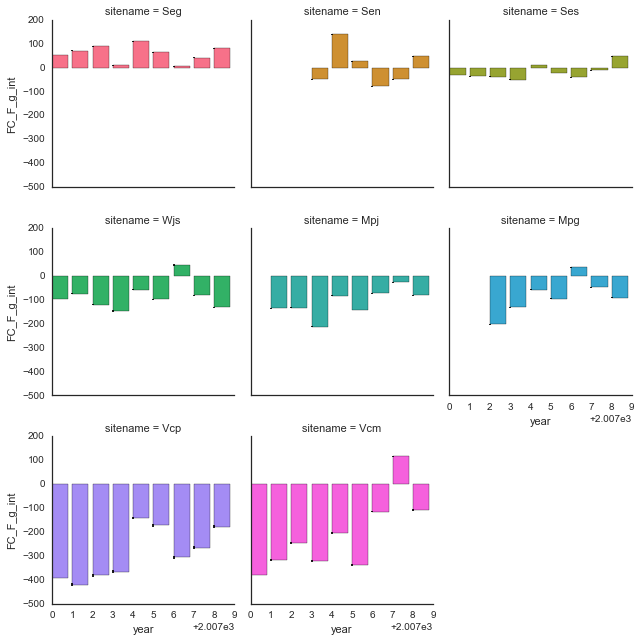

In [9]:
g = sns.FacetGrid(plotting_dfs['NEE'], col="sitename", hue="sitename", col_wrap=3)
g = g.map(plt.errorbar, "year", "FC_F_g_int", "mdv_sd", marker='', c='k', ls='None')
g = g.map(plt.bar, 'year', 'FC_F_g_int')
#g = g.map(plt.errorbar, "year+", "FC_F_g_int", "mdv_sd", marker='', c='k', ls='None')

g.savefig( fig_path + 'nmeg_annFC_mdvUnc.svg')

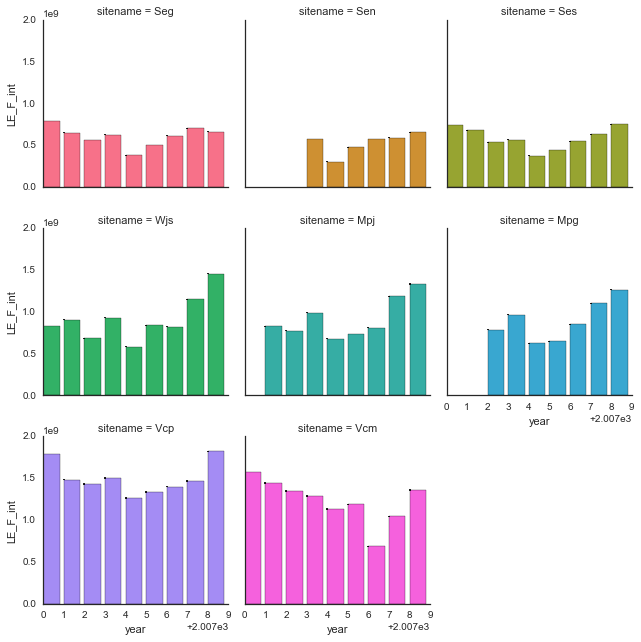

In [10]:

g = sns.FacetGrid(plotting_dfs['LE'], col="sitename", hue="sitename", col_wrap=3)
g = g.map(plt.errorbar, "year", "LE_F_int", "mdv_sd", marker='', c='k', ls='None')
g = g.map(plt.bar, 'year', 'LE_F_int')
#g = g.map(plt.errorbar, "year+", "FC_F_g_int", "mdv_sd", marker='', c='k', ls='None')

g.savefig( fig_path + 'nmeg_annLE_mdvUnc.svg')

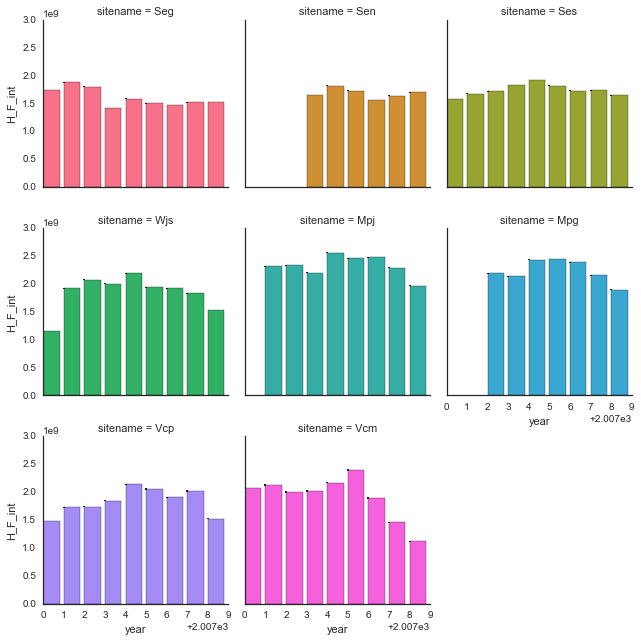

In [11]:
g = sns.FacetGrid(plotting_dfs['H'], col="sitename", hue="sitename", col_wrap=3)
g = g.map(plt.errorbar, "year", "H_F_int", "mdv_sd", marker='', c='k', ls='None')
g = g.map(plt.bar, 'year', 'H_F_int')
#g = g.map(plt.errorbar, "year+", "FC_F_g_int", "mdv_sd", marker='', c='k', ls='None')

g.savefig( fig_path + 'nmeg_annH_mdvUnc.svg')